# Eros Moreira Ferreira
16/07/2024

# Simulação Numérica da Dinâmica do Pêndulo Esférico

Reprodução do exemplo 8.10.1 do livro Scientific Computing with MATLAB and Octave 4th edition.

In [16]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


## Métodos Para a Solução da EDO

Para manter o máximo de fidelidade, usarei os mesmos códigos do livro que transcrevi para Python:

*   Foward Euler
*   Backward Euler
*   Crank-Nicolson

Usarei também o `solve_ivp` da biblioteca `scipy` para a solução com o RK23 = ODE23 e RK45 = ODE45.

### Foward Euler

In [17]:
# Foward Euler
def feuler(odefun, tspan, y, Nh):
    h = (tspan[1] - tspan[0]) / Nh  # tamanho do time step
    tt = np.linspace(tspan[0], tspan[1], Nh+1) # Time step
    
    # Redimensionando y para duas dimensões.
    y = y.reshape((1, -1)) # Isso possibilita a função lidar com um sistema de equações.
    
    for t in tt[1:]:
        y_new = y[-1] + h * odefun(t, y[-1])
        
        y = np.vstack((y, y_new))
        
    return tt, y

### Backward Euler

In [18]:
from scipy.optimize import fsolve

# Backward Euler
def beuler(odefun, tspan, y, Nh):
    h = (tspan[1] - tspan[0]) / Nh # tamanho time step
    tt = np.linspace(tspan[0], tspan[1], Nh+1) # time step
    
    y = y.reshape((1, -1)) 
    
    for t in tt[1:]:
        # Define o sistema de eq
        f = lambda w: w - y[-1] - h * odefun(t, w)
        
        # Resolve o sistema de eq
        w = fsolve(f, y[-1])
        
        y = np.vstack((y, w))
    
    return tt, y

### Crank-Nicolson

In [19]:
# Crank-Nicolson 
# Nessa eu pedi uma ajudinha da IA pra entender o código - horroroso - em MATLAB.

def cranknic(odefun, tspan, y0, Nh):
    tt = np.linspace(tspan[0], tspan[1], Nh+1)
    u = np.array(y0).reshape(1, -1)
    
    glob_h = (tspan[1] - tspan[0]) / Nh
    glob_y = np.array(y0)
    glob_odefun = odefun
    
    for glob_t in tt[1:]:
        def cranknicfun(w):
            return w - glob_y - 0.5 * glob_h * (glob_odefun(glob_t, w) + glob_odefun(glob_t - glob_h, glob_y))
        
        w = fsolve(cranknicfun, glob_y)
        u = np.vstack((u, w))
        glob_y = w
    
    return tt, u

## Fvinc

A função que representa o sistema de equações.

In [20]:
def fvinc(t, y):
    n = np.size(y)
    f = np.zeros(n)
    
    phix = 2*y[0]
    phiy = 2*y[1]
    phiz = 2*y[2]
    
    H = 2*np.eye(3)
    mass = 1
    
    F1 = 0
    F2 = 0
    F3 = -mass*9.8
    
    xp = np.array(y[3:6])
    
    
    F = np.array([F1, F2, F3])
    G = np.array([phix, phiy, phiz])
    
    lambda_val = (mass * xp.T @ H @ xp + F.T @ G) / (G.T @ G)
    
    f[0:3] = y[3:6]
    
    for k in range(3):
        f[k+3] = (F[k] - lambda_val * G[k]) / mass
    return f


## Plot Func

Como todos os gráficos são parecidos, achei melhor criar uma função apenas para isso.

Eu pretendia utilizar o Plotly para gerar gráficos 3d interativos, porém os gráficos eram tão pesados que o arquivo ficava imenso.
Caso queira tentar, deixei a implementação comentada. Basta comentar o outro.

Recomendo que não plot todos os gráficos de uma vez usando o Plotly. Plot um, limpe o output e plot outro.
O último é especialmente pesado pela quantidade grande de dados.

Não é possível plotar esses gráficos com o Plotly no Colab a menos que voce tenha pago para ter mais processamento.

In [21]:
# Plota usando o Plotly (gráficos 3d interativos, porém muito pesados).
"""
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def PlotSol(x1,y1,z1,x2,y2,z2,name1, name2,title, y0):
    
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]])

    #plot1
    fig.add_trace(go.Scatter3d(
            x=x1,
            y=y1,
            z=z1,
            mode='lines',
            name = str(name1)
            ),
        row=1, col=1
    )

    #plot2
    fig.add_trace(go.Scatter3d(
            x=x2,
            y=y2,
            z=z2,
            mode='lines',
            name = str(name2)
            ),
        row=1, col=2
    )

    # Adiciona o ponto inicial.
    fig.add_trace(go.Scatter3d(
            x = [y0[0]],
            y = [y0[1]],
            z = [y0[2]],
            mode = 'markers',
            name = 'y0',
            marker = dict(size=3, color='red')
            ),
        row = 'all', col = 'all'
    )

    fig.update_layout(height=800, width=1500, title_text= str(title))
    return fig
"""

"\nimport plotly.graph_objects as go\nfrom plotly.subplots import make_subplots\n\ndef PlotSol(x1,y1,z1,x2,y2,z2,name1, name2,title, y0):\n    \n    fig = make_subplots(\n        rows=1, cols=2,\n        specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]])\n\n    #plot1\n    fig.add_trace(go.Scatter3d(\n            x=x1,\n            y=y1,\n            z=z1,\n            mode='lines',\n            name = str(name1)\n            ),\n        row=1, col=1\n    )\n\n    #plot2\n    fig.add_trace(go.Scatter3d(\n            x=x2,\n            y=y2,\n            z=z2,\n            mode='lines',\n            name = str(name2)\n            ),\n        row=1, col=2\n    )\n\n    # Adiciona o ponto inicial.\n    fig.add_trace(go.Scatter3d(\n            x = [y0[0]],\n            y = [y0[1]],\n            z = [y0[2]],\n            mode = 'markers',\n            name = 'y0',\n            marker = dict(size=3, color='red')\n            ),\n        row = 'all', col = 'all'\n    )\n\n    fig.update_

In [22]:
# Plota usando o Matplotlib (gráficos 3d não interativos e feios).

def PlotSol(x1,y1,z1,x2,y2,z2,name1, name2,title, y0):
    
    fig = plt.figure(figsize=(15, 8))
    fig.suptitle(str(title))
    
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    #plot1
    ax1.plot(x1,y1,z1,)
    ax1.set_title(str(name1))
    
    #plot2
    ax2.plot(x2,y2,z2,)
    ax2.set_title(str(name2))

    # Adiciona o ponto inicial.
    ax1.scatter(y0[0], y0[1], y0[2], color = 'red', label = 'y0')
    ax2.scatter(y0[0], y0[1], y0[2], color = 'red', label = 'y0')
    
    ax1.legend()
    ax2.legend()
    
    return None

## Resultados

In [23]:
# Condições iniciais
y0 = np.array([0, 1, 0, .8, 0, 1.2])
tspan = [0, 25]


### Foward Euler

In [25]:
# Soluções com forward Euler
t_FE, sol_FE1 = feuler(fvinc, tspan, y0, 10000)
t_FE, sol_FE2 = feuler(fvinc, tspan, y0, 100000) # demorou consideravelmente mais.


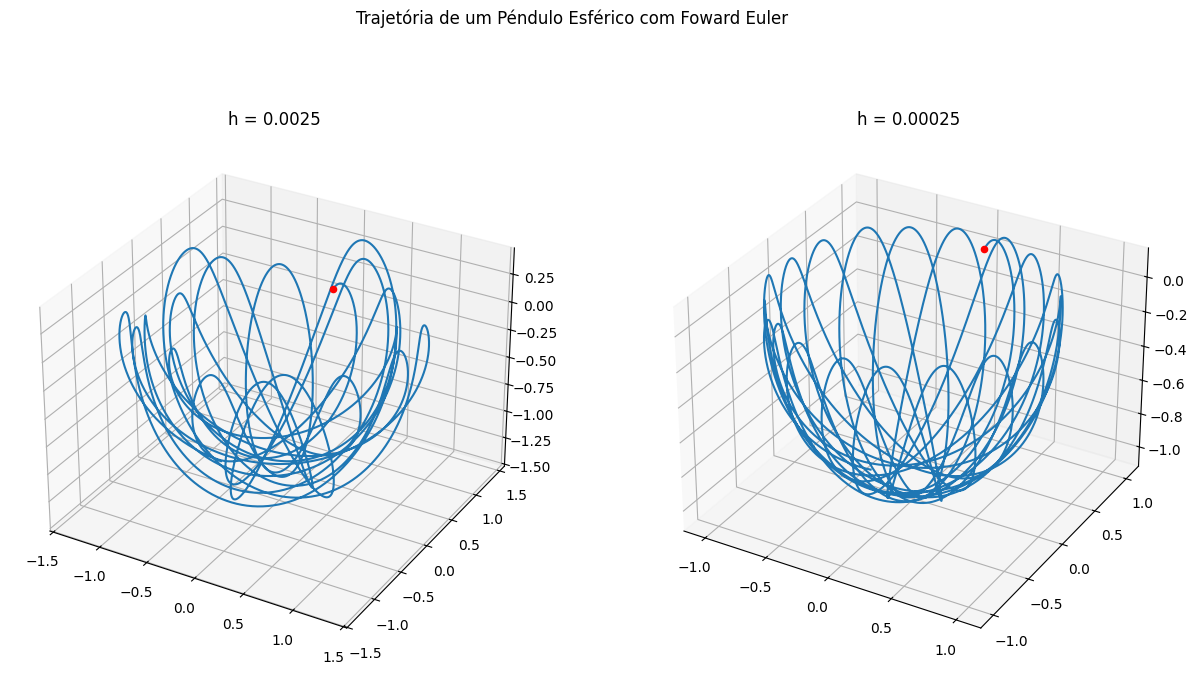

In [26]:

# Plota as soluções Foward Euler
plota = PlotSol(
        sol_FE1[ :, 0],
        sol_FE1[ :, 1],
        sol_FE1[ :, 2],
        sol_FE2[ :, 0],
        sol_FE2[ :, 1],
        sol_FE2[ :, 2],
        name1 = 'h = 0.0025',
        name2 = 'h = 0.00025',
        title = 'Trajetória de um Pêndulo Esférico com Foward Euler',
        y0 = y0
)
plota

Como mencionado no livro, podemos ter uma ideia da acurácia de cada método usado o fato de que a solução deve satisfazer

\begin{equation}
    r(y) = y_1^2 + y_2^2 + y_3^2 -1 = 0
\end{equation}

sendo que $y_1, y_2$ e $y_3$ é a posição $x,y,z$ no instante de tempo $t_n$.

In [27]:
r1 = abs(sol_FE2[-1,0]**2 + sol_FE2[-1,1]**2 + sol_FE2[-1,2]**2 -1)
r2 = abs(sol_FE1[-1,0]**2 + sol_FE1[-1,1]**2 + sol_FE1[-1,2]**2 -1)
print(f"O residuo r para o Forward Euler com h = 0.00025 é {r1:.4f} e com h = 0.0025 é {r2:.4f}")

O residuo r para o Forward Euler com h = 0.00025 é 0.1111 e com h = 0.0025 é 1.0578


Os resultados são idênticos ao do livro.

> By using 10.000 discretization nodes we find $r = 1.0578$, while
with 100.000 nodes we have $r = 0.1111$, in accordance with the theory
requiring the explicit Euler method to converge with order 1.

### Backward Euler e Crank Nicolson

In [28]:
# Solução com o backward Euler.
t, Sol_beuler = beuler(fvinc, tspan, y0, 20000)

In [29]:
# Solução com Cranl-Nicolson
t, sol_CN = cranknic(fvinc, tspan, y0, 1000)

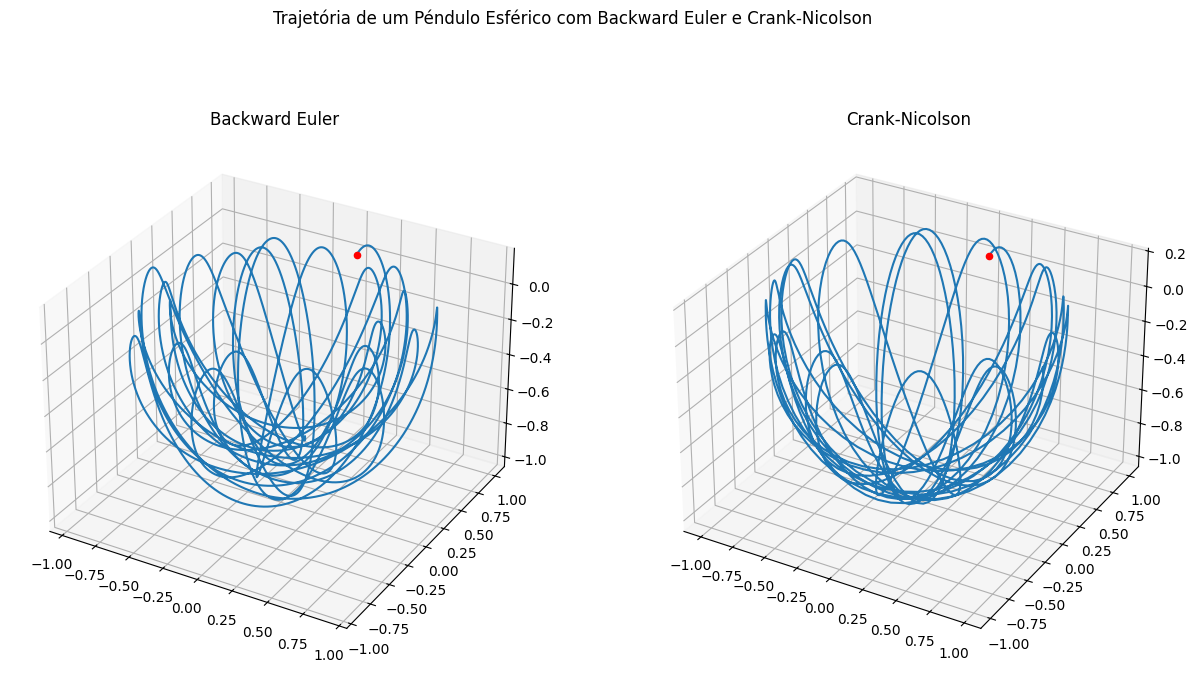

In [30]:
# Plota os resultados com RK23 e RK45

Plot = PlotSol(
        Sol_beuler[ :, 0],
        Sol_beuler[ :, 1],
        Sol_beuler[ :, 2],
        sol_CN[ :, 0],
        sol_CN[ :, 1],
        sol_CN[ :, 2],
        name1 = 'Backward Euler',
        name2 = 'Crank-Nicolson',
        title = 'Trajetória de um Pêndulo Esférico com Backward Euler e Crank-Nicolson',
        y0 = y0
)

Plot

In [31]:
rbeuler = abs(Sol_beuler[-1,0]**2 + Sol_beuler[-1,1]**2 + Sol_beuler[-1,2]**2 -1)
rCN = abs(sol_CN[-1,0]**2 + sol_CN[-1,1]**2 + sol_CN[-1,2]**2 -1)
print(f"O residuo r para o Backward Euler é {rbeuler:.4f} e o residuo r para o Crank-Nicolson é {rCN:.4f}")

O residuo r para o Backward Euler é 0.5816 e o residuo r para o Crank-Nicolson é 0.0928


Aqui tambem temos um resultado parecido.

> By using the implicit Euler method with 20000 steps we obtain the
 solution reported in Figure 8.19, while the Crank-Nicolson method (of
 order 2) with only 1000 steps provides the solution reported in the same
 ﬁgure on the right, which is undoubtedly more accurate. Indeed, we ﬁnd
 $r = 0.5816$ for the implicit Euler method and $r = 0.0928$ for the Crank-
 Nicolson method.

### RK23 e RK45

In [32]:
t = np.linspace(tspan[0], tspan[1], 1000000)

# Solução com RK23
sol_RK23 = solve_ivp(fvinc, [tspan[0], tspan[-1]], y0, t_eval=t, method="RK23")


# Solução com RK45
sol_RK45 = solve_ivp(fvinc, [tspan[0], tspan[-1]], y0, t_eval=t)

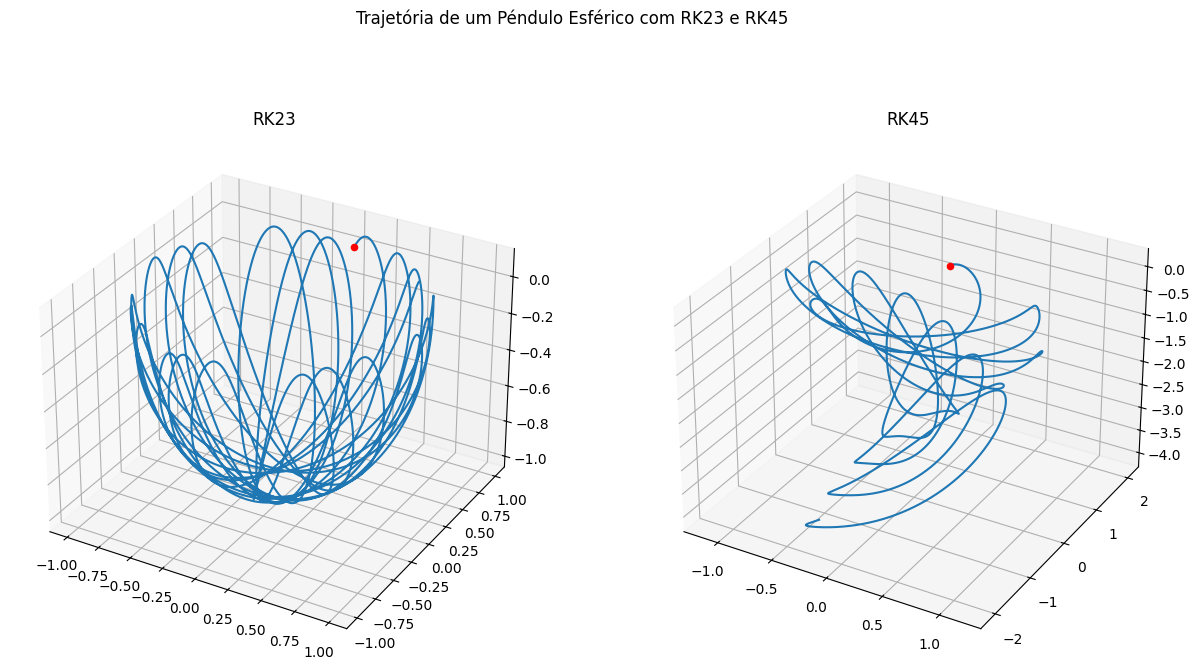

In [33]:
# PLota os resultados com RK23 e RK45

Plot = PlotSol(
        sol_RK23.y[0, :],
        sol_RK23.y[1, :],
        sol_RK23.y[2, :],
        sol_RK45.y[0, :],
        sol_RK45.y[1, :],
        sol_RK45.y[2, :],
        name1 = 'RK23',
        name2 = 'RK45',
        title = 'Trajetória de um Pêndulo Esférico com RK23 e RK45',
        y0 = y0)

Plot

In [34]:
r_RK23 = abs(sol_RK23.y[0,-1]**2 + sol_RK23.y[1,-1]**2 + sol_RK23.y[2,-1]**2 -1)
r_RK45 = abs(sol_RK45.y[0,-1]**2 + sol_RK45.y[1,-1]**2 + sol_RK45.y[2,-1]**2 -1)
print(f"O residuo r para o RK23 é {r_RK23:.4f} e o residuo r para o RK45 é {r_RK45:.4f}")

O residuo r para o RK23 é 0.0237 e o residuo r para o RK45 é 17.2491


Já aqui têmos resultados diferentes do livro.

> The residual $r$ is equal to $0.0238$ for ode23
 and $ 3.2563 $ for ode45

### RK23 e RK45 Com rtol = 1e-4

In [35]:
# Solução com RK23
sol_RK23_rtol = solve_ivp(fvinc, [tspan[0], tspan[-1]], y0, t_eval=t, method="RK23", rtol = 1e-4)

# Solução com RK45
sol_RK45_rtol = solve_ivp(fvinc, [tspan[0], tspan[-1]], y0, t_eval=t, rtol = 1e-4)

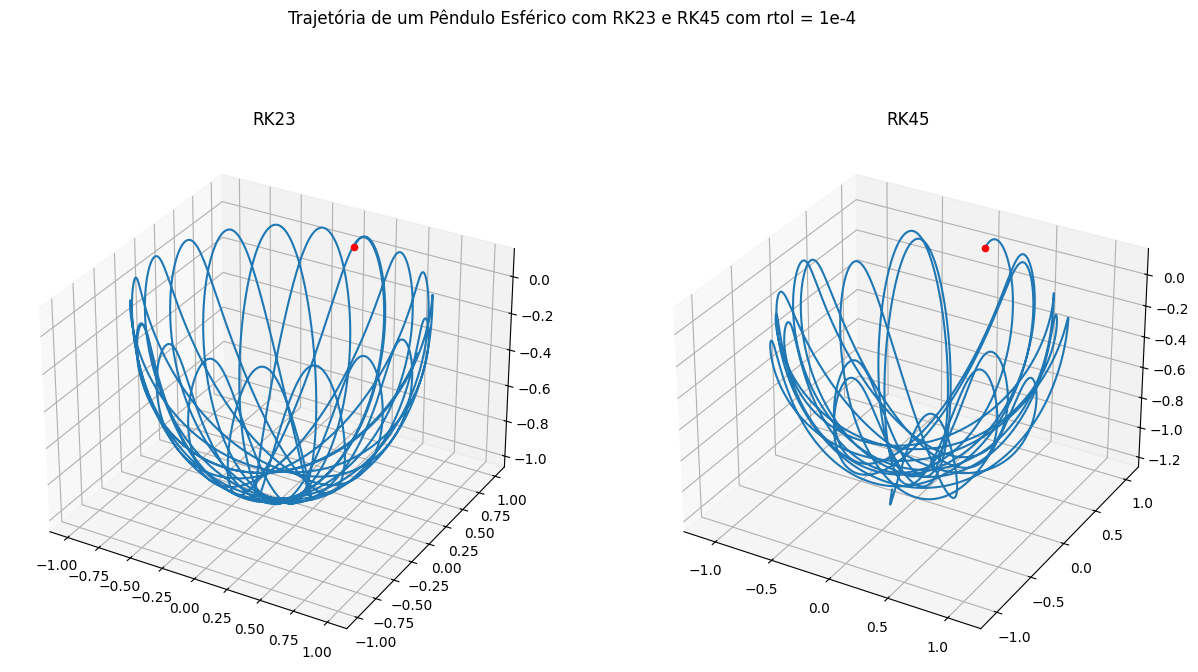

In [40]:
# Plota os resultados para RK23 e RK45 com rtol = 1e-4

Plot = PlotSol(
        sol_RK23_rtol.y[0, :],
        sol_RK23_rtol.y[1, :],
        sol_RK23_rtol.y[2, :],
        sol_RK45_rtol.y[0, :],
        sol_RK45_rtol.y[1, :],
        sol_RK45_rtol.y[2, :],
        name1 = 'RK23',
        name2 = 'RK45',
        title = 'Trajetória de um Pêndulo Esférico com RK23 e RK45 com rtol = 1e-4',
        y0 = y0)

Plot

O possível ver que o plot do RK23 com rtol= 1e-4 foi o melhor de todos.

O plot do RK45 ficou mais parecido com o do livro ajustando rtol = 1e-5

In [37]:
r_RK23_rtol = abs(sol_RK23_rtol.y[0,-1]**2 + sol_RK23_rtol.y[1,-1]**2 + sol_RK23_rtol.y[2,-1]**2 -1)
r_RK45_rtol = abs(sol_RK45_rtol.y[0,-1]**2 + sol_RK45_rtol.y[1,-1]**2 + sol_RK45_rtol.y[2,-1]**2 -1)
print(f"O residuo r para o RK23 é {r_RK23_rtol:.4f} e o residuo r para o RK45 é {r_RK45_rtol:.4f}")

O residuo r para o RK23 é 0.0052 e o residuo r para o RK45 é 0.4169


Aqui também temos resultados bem diferntes pro RK45.

>Precisely ode23 ... provides a residual $r = 0.003$,
while ode45 ... provides a residual $r = 0.060.$

Tanto nesse quanto no anterior, $r_{(RK45)} \approx 5r_{(livro)}$